In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [2]:
df = pd.read_csv('../Data/address_data_combined.csv')
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342


In [3]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(9908, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
6709,17.06,0.00,51.17,1,101.0000,101.000000,101.000000,10.804780,33.666149,4,101.000000,0.001554
13808,2679.43,2841.02,275214.32,21,0.0001,15.000000,2.295850,0.000000,1.877316,100,103.313259,0.060902
8333,103299.49,37551.75,826452.87,6,0.0000,52.532971,23.290155,0.000000,16.627500,15,163.031084,30.011085
6981,4756.98,11283.84,46352.60,1,11.0000,20.000000,15.500000,9.975152,10.194942,7,31.000000,-19.974711
676,0.00,0.00,0.00,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [4]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
  X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)
columns = X_train_full.columns

# Scaling
# only use training data to fit, to avoid data leakage
# Not required for Naive Bayes but performed to ensure all variables are standardized through all ML models
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(9908, 12))

In [5]:
params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [20, 50, 100, 500, 1000],
    "max_depth": [i for i in range(3, 12)],
    "max_bin": [200, 300],
    "min_gain_to_split": [i for i in range(0, 15, 5)],
    "bagging_fraction": [0.2, 0.3, 0.5, 0.7, 0.95],
    "bagging_freq": [1],
    "feature_fraction": [0.2, 0.3, 0.5, 0.7, 0.95]
}


In [6]:
clf = lgb.LGBMClassifier()

tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=0,
                         )

In [7]:
import warnings
warnings.filterwarnings("ignore")
#tuned_clf.fit(X_train_full,y_train_full, verbose = 0)

In [8]:
lightgbm_params = {"bagging_fraction": 0.95, 
                   "bagging_freq": 1,
                   "feature_fraction": 0.95,
                   "learning_rate": 0.2,
                   "max_bin": 300, 
                   "max_depth": 6,
                   "min_gain_to_split": 0,
                   "num_leaves": 20}

lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
lightgbm_model.fit(X_train_full, y_train_full)

[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 4562, number of 

,boosting_type,'gbdt'
,num_leaves,20
,max_depth,6
,learning_rate,0.2
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, col

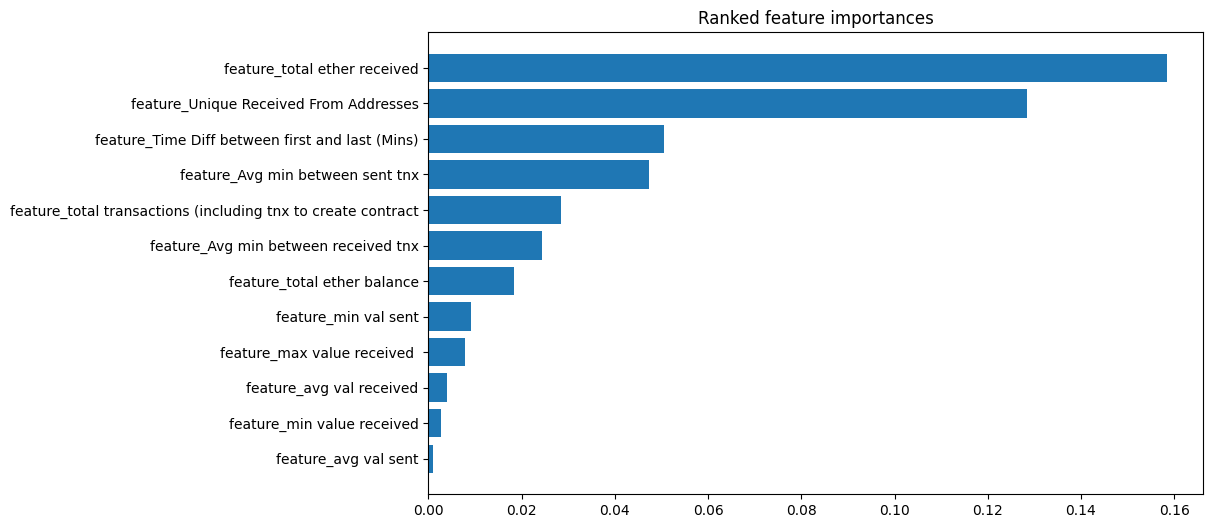

In [9]:
from sklearn.inspection import permutation_importance
feat_importances = permutation_importance(lightgbm_model, X_test, y_test)['importances_mean']
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [10]:
best_y_pr = lightgbm_model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, best_y_pr))
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Accuracy Score:  0.9352484106428067
Test F1 Score:  0.9300788202390033
